In [143]:
import pandas as pd
import numpy as np

import datetime as dt

import holidays
from calendra.asia import Qatar
from calendra.asia import HongKong

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, SCORERS
from sklearn.utils import resample

import statsmodels.api as sm
import scipy.stats as stats



import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
import pandas as pd
import numpy as np
import datetime as dt

class DataRetrieval():
    
    #def __init__(self):

    
    def get_calls_data(self, filepath='../data/Calls_Table_data.csv', delimiter='\t'):
        """Retrieves call data from filepath"""
        df = pd.read_csv(filepath, delimiter='\t', encoding='utf-16')
        df.drop_duplicates(inplace=True)
        df.reset_index(drop=True, inplace=True)        
        return df
    
    def get_weather_data(self, filepath='../data/historical_weather.csv'):
        """Retrieves weather data from filepath"""
        df = pd.read_csv(filepath)
        df['date'] = pd.to_datetime(df['DATE']).dt.date
        weather_hist = (df[['date', 'TMAX', 'PRCP', 'SNOW']]
                        .rename(columns={'PRCP':'precip', 'TMAX':'temp_max',
                                         'PRCP':'precip', 'SNOW':'snow'}))
        weather_hist['precip^2'] = weather_hist['precip']**2
        weather_hist['snow^2'] = weather_hist['snow']**2      
        return weather_hist
    
    def get_seahawks_schedule(self, filepath='../data/seahawks_schedule.csv'):
        """
        Retrieves Seahawks game schedule from filepath
        
        Will need to rewrite scraper used to retrieve this data
        """
        df_in = pd.read_csv(filepath)
        df_dropna = df_in.copy()[df_in['Opp'].notna()].reset_index(drop=True)
        df = df_dropna.copy()[df_dropna['Opp'] != 'Bye Week'].reset_index(drop=True)
        
        
        df['date'] = ''
        for i in range(len(df)):
            df['date'][i] = (f"{df.iloc[i]['Date']}, {df.iloc[i]['year']}")
            
        df['date'] = pd.to_datetime(df['date']).dt.date
        
        df['seahawks_game'] = ''
        for i in range(len(df)):
            if type(df.iloc[i]['Unnamed: 10']) == str:
                if df.iloc[i]['Week'] == 'SuperBowl':
                    df['seahawks_game'][i] = 'SuperBowl'
                elif df.iloc[i]['Week'] in ['Wild Card', 'Division','Conf. Champ.']:
                    df['seahawks_game'][i] = 'away_Playoffs'
                else:
                    df['seahawks_game'][i] = 'away_Regular'
            else:     
                if df.iloc[i]['Week'] == 'SuperBowl':
                    df['seahawks_game'][i] = 'SuperBowl'
                elif df.iloc[i]['Week'] in ['Wild Card', 'Division','Conf. Champ.']:
                    df['seahawks_game'][i] = 'home_Playoffs'
                else:
                    df['seahawks_game'][i] = 'home_Regular'
        return df[['date', 'seahawks_game']].copy()
    
    def get_huskies_schedule(self, filepath='../data/huskies_schedule.csv'):
        """
        Retrieves Huskies game schedule from filepath

        Will need to rewrite scraper used to retrieve this data
        """
        df_in = pd.read_csv(filepath)
        df = df_in.copy()
        df['date'] = pd.to_datetime(df['Date']).dt.date

        df['huskies_game'] = ''
        for i in range(len(df)):
            if type(df.iloc[i]['Unnamed: 6']) == str:
                df['huskies_game'][i] = 'away'
            else:
                df['huskies_game'][i] = 'home'
        return df[['date','huskies_game']].copy()

    def get_sounders_schedule(self, filepath='../data/sounders_schedule.csv'):
        """
        Retrieves Sounders FC game schedule from filepath

        Will write instructions for getting game data
        """
        df_in = pd.read_csv(filepath)
        df = df_in.copy()
        df['date'] = pd.to_datetime(df_in['date_dd_mm_yy']).dt.date
        
        df['sounders_game'] = ''
        for i in range(len(df)):
            if df['home_team'][i].split()[0] == 'Seattle':
                df['sounders_game'][i] = 'home'
            else:
                df['sounders_game'][i] = 'away'
        return df[['date','sounders_game']].drop_duplicates()



In [90]:
import pandas as pd
import numpy as np
import datetime as dt

import holidays
from calendra.asia import Qatar
from calendra.asia import HongKong

class SeattleHolidays:
    
    
    class CustomHolidays(holidays.US):
        def _populate(self, year=2019, start_year=2009, end_year=2030):
            # Populate the holiday list with the default US holidays
            holidays.US._populate(self, year)
            # Example: Add Ninja Turtle Day
            #self[dt.date(year, 7, 13)] = "Ninja Turtle Day"
            for year in range(start_year, end_year):
                # Add Valentine's day
                self[dt.date(year, 2, 14)] = "Valentines Day"
                # Add St Patricks Day
                self[dt.date(year, 3, 17)] = "St Patricks Day"
                # Add Easter
                self[holidays.easter(year=year)] = "Easter"
                # Add Good Friday
                self[holidays.easter(year=year)  -  dt.timedelta(days=2)] = "Good Friday"
                # Add May Da
                self[dt.date(year, 5, 1)] = "May Day"
                # Add Cinco De Mayo
                self[dt.date(year, 5, 5)] = "Cinco De Mayo"
                # Add Halloween
                self[dt.date(year, 10, 31)] = "Halloween"
                # Add Día de Muertos
                self[dt.date(year, 11, 2)] = "Halloween"
                # Add Christmas Eve
                self[dt.date(year, 12, 24)] = "Christmas Eve"
                # Add New Years Eve
                self[dt.date(year, 12, 31)] = "New Years Eve"
                # Add Chinese New Year
                chinese = HongKong()
                for date, label in chinese.get_chinese_new_year(year):
                    self[date] = label


    class IslamicHolidays(holidays.HolidayBase):
        def _populate(self, year=2019, start_year=2009, end_year=2030):
            qatar_holidays = Qatar()
            # Populate the holiday list with blank base holidays
            holidays.HolidayBase._populate(self, year)
            for year in range(start_year, end_year):
                days = qatar_holidays.get_calendar_holidays(year)
                # Add Ramadan
                for i in range(1, len(days)):
                    if qatar_holidays.get_calendar_holidays(year)[i][1] == 'Start of ramadan':
                        for day in range(30):
                            self[qatar_holidays.get_calendar_holidays(year)[i][0] 
                                 + dt.timedelta(days=day-1)] = "Ramadan"
                    else:
                        self[qatar_holidays.get_calendar_holidays(2018)[1][0] 
                             - dt.timedelta(days=2)] = qatar_holidays.get_calendar_holidays(year)[i][1]


    class JewishHolidays(holidays.HolidayBase):
        def retrieve_data(self, filepath):
            df = pd.read_csv(filepath)
            return df

        def get_holidays(self, paths_list):
            df = self.retrieve_data(paths_list[0])
            for filepath in paths_list[1 : ]:
                cal = self.retrieve_data(filepath)
                df = pd.concat([df, cal])
            return df

        def _populate(self, year=2019, paths_list=['../data/hebcal_2010_usa.csv',
                                                   '../data/hebcal_2015_usa.csv', 
                                                   '../data/hebcal_2020_usa.csv',
                                                   '../data/hebcal_2025_usa.csv'],
                      start_year=2009, end_year=2030):
            hebcal = self.get_holidays(paths_list)
            hebcal.reset_index(drop=True, inplace=True)
            hebcal['date'] = pd.to_datetime(hebcal["Start Date"]).dt.date
            # Populate the holiday list with blank base holidays
            holidays.HolidayBase._populate(self, year)
            for year in range(start_year, end_year):
                for i in range(len(hebcal)):
                    self[hebcal['date'][i]] = hebcal['Subject'][i]


In [91]:
import pandas as pd
import numpy as np
import datetime as dt


class CountCalls():
    """Counts calls by date either by city or neighborhood"""
    
    def __init__(self, how='city'):
        self.how = how
        self.X = None
        self.y = None
        
    def fit(self, X, y=None):
        self.X = X
        self.y = y
        self.how = self.how
        return self
    
    def transform(self, y=None):
        
        if self.how == 'city':
            df = self.X[['ORIG_TIME_QUEUED', 'EVENT']].copy()
            df['date'] = pd.to_datetime(df['ORIG_TIME_QUEUED']).dt.date
            df.drop('ORIG_TIME_QUEUED', axis=1, inplace=True)
            return df.groupby('date').count().rename(columns={'EVENT':'num_calls'}).reset_index()
        
        else:
            df = self.X[['NEIGHBORHOOD', 'ORIG_TIME_QUEUED', 'EVENT']].copy()
            df['date'] = pd.to_datetime(df['ORIG_TIME_QUEUED']).dt.date
            df.drop('ORIG_TIME_QUEUED', axis=1, inplace=True)
            counts = df.groupby(['NEIGHBORHOOD', 'date']).count().rename(columns=
                                                                         {'NEIGHBORHOOD':'neighborhood',
                                                                          'EVENT':'num_calls'}).reset_index()
            
            neighborhoods = list(counts['NEIGHBORHOOD'].unique())
            num_days = int(np.timedelta64((max(counts['date']) - min(counts['date'])), 'D')/np.timedelta64(1,'D'))+1
            start = pd.to_datetime(min(counts['date']))
            neighboor_arr = np.array([(neighborhoods*num_days)])
            neighboor_arr = neighboor_arr.flatten()
            dates = [(start + np.timedelta64(i,'D')) for i in range(num_days)]*len(neighborhoods)
            
            df2 = pd.DataFrame({"dt_time": dates})
            df2['date'] = df2["dt_time"].dt.date
            df2['neighborhood'] = neighboor_arr
            df3 = pd.merge(df2, counts, how='outer', left_on=['date','neighborhood'],
                           right_on=['date','NEIGHBORHOOD']).fillna(0)
            return df3[['date', 'neighborhood', 'num_calls']]
        
        

class FeaturizeCalls():
    """Clean incoming df to fit into model"""
    
    def __init__(self):
        self.X = None
        self.y = None
    
    def fit(self, X, y=None):
        self.X = X
        self.y = y
        return self

    
    def transform(self, y=None):
        """tranform and clean incoming training or test"""
    
        df = self.X.copy()
        num_days = int(np.timedelta64((max(df['date']) - min(df['date'])), 'D')/np.timedelta64(1,'D'))+1
        start = pd.to_datetime(min(df['date']))
        dates = [(start + np.timedelta64(i,'D')) for i in range(num_days)]

        seq = pd.DataFrame({'dt_time': dates, 'day_seq':np.arange(num_days)})
        seq['date'] = seq['dt_time'].dt.date

        df1 = df.join(seq.set_index('date'), on='date')

        df1['year'] = df1['dt_time'].dt.year
        df1['month'] = df1['dt_time'].dt.month
        df1['day'] = df1['dt_time'].dt.day
        df1['day_of_week'] = df1['dt_time'].dt.weekday
        df1['month_day'] = df1['dt_time'].dt.strftime('%m/%d')
        df1['month_weekday'] = df1['dt_time'].dt.strftime('%b_%a')
        df1['month'] = df1['dt_time'].dt.strftime('%m/%d')     
        return df1


class DateDummies():

    def __init__(self):
        self.X = None
        self.y = None
    
    def fit(self, X, y=None):
        # X is the featurized calls dataframe
        self.X = X 
        self.y = y
        return self

    def transform(self, y=None):
        day_features= ['01/06','01/14','02/02','02/07','03/01','03/10','03/20','03/26','04/01','04/08',
                       '04/17','04/18','05/06','05/09','05/10','05/21','05/31','06/04','06/05','06/13',
                       '06/28','06/30','07/09','07/16','07/20','07/23','07/29','08/01','08/20','08/24',
                       '08/28','09/08','09/11','09/14','09/30','10/02','10/17','10/26','11/01','11/15',
                       '11/16','11/23','11/27','12/04','12/12','12/19','12/21','12/23','12/29']
        spec_days = pd.DataFrame({'month_day':day_features, 'spec_day':day_features})
        df =self.X.join(spec_days.set_index('month_day'), on='month_day')

        date_dummies =  pd.get_dummies(df[['date', 'day', 'month_weekday', 'spec_day']].set_index('date'),
                                       columns=['day', 'month_weekday', 'spec_day']).reset_index().drop_duplicates()
        return df.join(date_dummies.set_index('date'), on='date').fillna(0)   
    

class HolidayDummies():
    
    def __init__(self):
        self.X = None
        self.y = None
    
    def fit(self, X, y=None):
        # X is a dictionary of Holidays
        self.X = X 
        self.y = y
        return self

    def transform(self):
        _holidays = []
        for date in sorted(self.X.keys()):
            _holidays.append([date, self.X[date]])
        _holidays = pd.DataFrame(_holidays, columns=['date', 'holiday'])
        return pd.get_dummies(_holidays.set_index('date')).reset_index()
    
    
class EventDummies():
    
    def __init__(self, event_dict=None):
        self.X = None
        self.y = None
        self.event_dict = event_dict

        defualt_events = ({'Pride Parade' : ['6/30/2019', '6/24/2018', '6/25/2017', '6/26/2016', '6/28/2015',
                                          '6/29/2014', '6/30/2013', '6/24/2012', '6/26/2011', '6/27/2010'],
                            'Seafair' : ['8/2/2019', '8/3/2019', '8/4/2019', '8/3/2018', '8/4/2018', '8/5/2018',
                                         '8/4/2017', '8/5/2017', '8/6/2017', '8/5/2016', '8/6/2016', '8/7/2016',
                                         '7/31/2015', '8/1/2015', '8/2/2015', '8/1/2014', '8/2/2014', '8/3/2014',
                                         '8/2/2013', '8/3/2013', '8/4/2013', '8/3/2012', '8/4/2012', '8/5/2012',
                                         '8/5/2011', '8/6/2011', '8/7/2011', '8/6/2010', '8/7/2010', '8/8/2010' ],
                            'Soltice Parade': ['6/30/2019', '6/16/2018', '6/17/2017', '6/18/2016', '6/20/2015',
                                               '6/21/2014', '6/22/2013', '6/16/2012', '6/18/2011', '6/19/2010'],
                            'Womens March' : ['1/19/2019', '1/20/2018', '1/21/2017'],})
        
        if self.event_dict == None:
            self.event_dict = defualt_events
        
    
    def fit(self, X=None, y=None):
        self.X = X 
        self.y = y
        return self
    
    def transform(self):
        _events = []
        for event in self.event_dict.keys():
            for day in self.event_dict[event]:
                _events.append([dt.datetime.strptime(day, '%m/%d/%Y'), event])
                
        _events = pd.DataFrame(_events, columns=['date','local_event'])
        _events['date'] = _events['date'].dt.date
        return pd.get_dummies(_events.set_index('date')).reset_index()
    
    
class MakeDummies():
    
    def __init__(self):
        self.X = None
        self.y = None
    
    def fit(self, X, y=None):
        # X is a dataframe of sporting events
        self.X = X 
        self.y = y
        return self

    def transform(self):
        return pd.get_dummies(self.X.set_index('date')).reset_index()    
        

class JoinDataFrames():
    
    def __init__(self, weather, us_holidays, islamic_holidays, 
                 jewish_holidays, events, seahawks, huskies, sounders):
        self.weather = weather
        self.us_holidays = us_holidays
        self.islamic_holidays = islamic_holidays
        self.jewish_holidays = jewish_holidays
        self.events = events
        self.seahawks = seahawks
        self.huskies = huskies
        self.sounders = sounders
        self.X = None
        self.y = None

    def fit(self, X, y=None):
        self.X = X
        self.y = y
        return self
    
    def transform(self):
        df1 = self.join_dfs(self.X, self.weather)
        df2 = self.join_dfs(df1, self.us_holidays)
        df3 = self.join_dfs(df2, self.islamic_holidays)
        df4 = self.join_dfs(df3, self.jewish_holidays)
        df5 = self.join_dfs(df4, self.events)
        df6 = self.join_dfs(df5, self.seahawks)
        df7 = self.join_dfs(df6, self.huskies)
        df8 = self.join_dfs(df7, self.sounders)
        return df8.fillna(0)
            
    def join_dfs(self, df1, df2):
        return df1.join(df2.set_index('date'), on='date')



In [92]:
retriever = DataRetrieval()

In [93]:
calls = retriever.get_calls_data()

In [94]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline

calls_pipe = Pipeline(steps=[
    ('counter', CountCalls(how='city')),
    ('feturizer', FeaturizeCalls()),
    ('date_dummifier', DateDummies())
])

In [95]:
data = calls_pipe.fit(calls)

In [96]:
calls_w_features = data.transform(calls)

In [6]:


pipe = Pipeline(steps=[
    ('counter', CountCalls()),
    ('feturizer', FeaturizeCalls()),
    ('date_dummifier', DateDummies()),
    ('us_holidays', HolidayDummies()),
    ('islamic_holidays', HolidayDummies()),
    ('jewish_holidays', HolidayDummies()),
    ('event_dummifier', EventDummies()),
    ('seahawks_dummifier', MakeDummies()),
    ('huskies_dummifier', MakeDummies()),
    ('ssounders_dummifier', MakeDummies()),
    ('data_joiner', JoinDataFrames())
])


TypeError: __init__() missing 8 required positional arguments: 'weather', 'us_holidays', 'islamic_holidays', 'jewish_holidays', 'events', 'seahawks', 'huskies', and 'sounders'

In [97]:
len(calls_w_features)

3195

In [98]:
len(calls_w_features)

3195

In [99]:
weather = retriever.get_weather_data()

In [100]:
seahawks_schedule = retriever.get_seahawks_schedule()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [101]:
huskies_schedule = retriever.get_huskies_schedule()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [102]:
sounders_schedule = retriever.get_sounders_schedule()

In [103]:
sports = MakeDummies()

In [104]:
sports.fit(seahawks_schedule)

In [105]:
seahawks = sports.transform()

In [106]:
sports.fit(huskies_schedule)

In [107]:
huskies = sports.transform()

In [108]:
sports.fit(sounders_schedule)

In [109]:
sounders = sports.transform()

In [110]:
us_holiday_dict = SeattleHolidays.CustomHolidays()

In [111]:
us_holiday_dict._populate()

In [112]:
holidayier = HolidayDummies()

In [113]:
holidayier.fit(us_holiday_dict)

In [114]:
us_holidays = holidayier.transform()

In [115]:
jewish_holiday_dict = SeattleHolidays.JewishHolidays()

In [116]:
jewish_holiday_dict._populate()

In [117]:
holidayier.fit(jewish_holiday_dict)

In [118]:
jewish_holidays = holidayier.transform()

In [119]:
islamic_holiday_dict = SeattleHolidays.IslamicHolidays()

In [120]:
islamic_holiday_dict._populate()

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '
/anaconda3/lib/python3.6/sit

In [121]:
holidayier.fit(islamic_holiday_dict)

In [122]:
islamic_holidays = holidayier.transform()

In [123]:
event_dummies = EventDummies()

In [124]:
event_dummies.fit()

In [125]:
events = event_dummies.transform()

In [126]:
joiner = JoinDataFrames(weather, us_holidays, islamic_holidays, jewish_holidays,
                        events, seahawks, huskies, sounders)

In [127]:
joiner.fit(calls_w_features)

In [128]:
calls_city = joiner.transform()

In [129]:
len(calls_city)

3195

In [130]:
train_set, test_set = train_test_split(calls_city, test_size=0.2, random_state=157)

In [131]:
X_train = train_set.drop(labels= ['date', 'num_calls', 'dt_time','year',
                                    'month', 'day','day_of_week', 'month_day',
                                    'month_weekday','spec_day'], axis=1)
y_train = train_set['num_calls']


X_test = test_set.drop(labels= ['date', 'num_calls', 'dt_time','year',
                                    'month', 'day','day_of_week', 'month_day',
                                    'month_weekday','spec_day'], axis=1)
y_test = test_set['num_calls']


In [132]:
city_model = LinearRegression()

In [134]:
X_train.shape

(2556, 277)

In [135]:
city_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [136]:
city_model.score(X_train, y_train)

0.28574807299339033

In [137]:
train_predictions = city_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)

test_predictions = city_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)

In [138]:
train_mse, test_mse

(29.878181972561404, 35.790297252577304)

In [ ]:
params = pd.DataFrame(np.round(np.append(linear_model.intercept_,linear_model.coef_), decimals=4))

In [ ]:
print(params)

In [139]:
chart_df = calls_city.drop(labels= ['date', 'num_calls', 'dt_time','year',
                                    'month', 'day','day_of_week', 'month_day',
                                    'month_weekday','spec_day'], axis=1)

In [153]:
chart_predictions = city_model.predict(chart_df)

In [154]:
calls_city['date'].shape

(3195,)

In [155]:
chart_predictions.shape

(3195,)

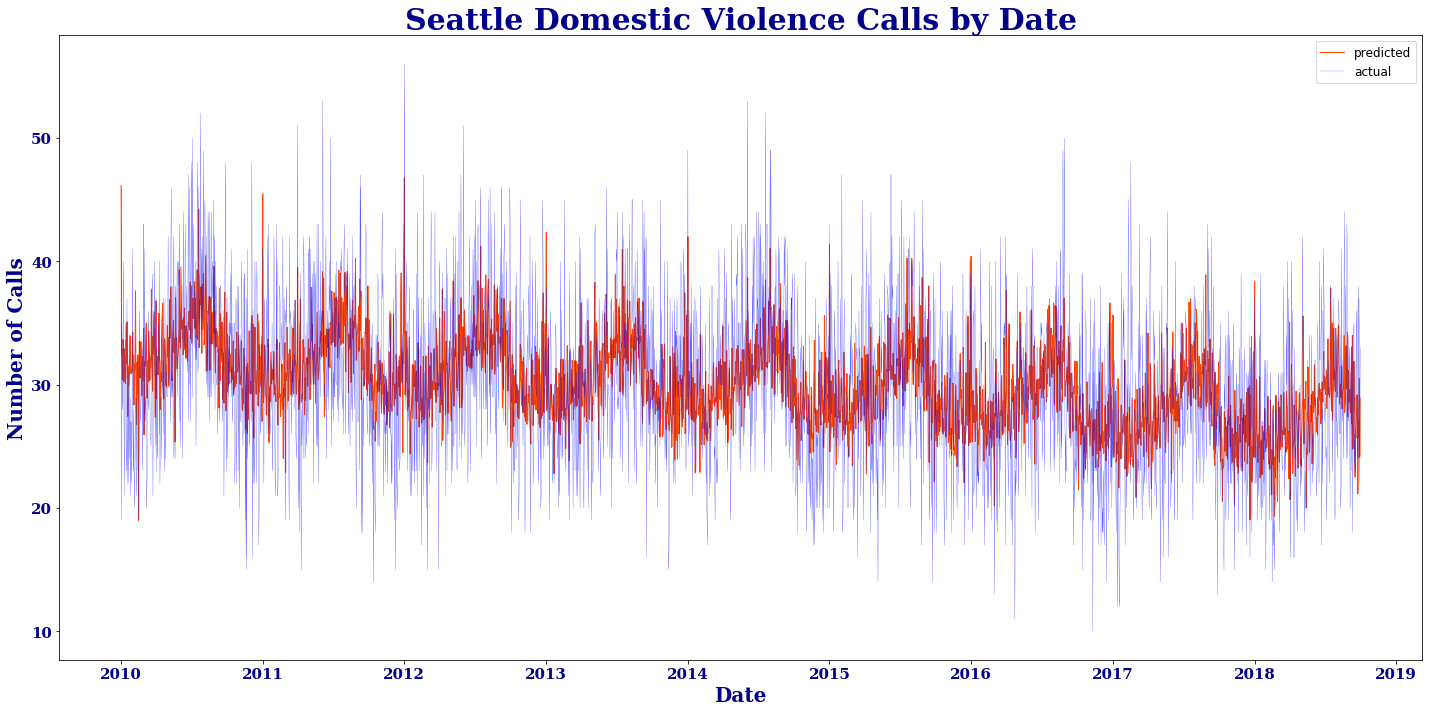

In [208]:
fig, axs = plt.subplots(1, figsize=(20,10))

axs.plot(calls_city['date'], chart_predictions, lw=1, color='orangered')
axs.plot(calls_city['date'], calls_city['num_calls'], lw=0.2, color='blue')
axs.set_title('Seattle Domestic Violence Calls by Date', fontdict={'family': 'serif','color':  'darkblue','weight': 'bold','size': 30,})
axs.set_ylabel('Number of Calls', fontdict={'family': 'serif','color':  'darkblue','weight': 'semibold','size': 20,})
axs.set_yticklabels(list(range(0, 70, 10)), fontdict={'family': 'serif','color':  'darkblue','weight': 'semibold','size': 15,})
axs.set_xticklabels(list(range(2010, 2020)), fontdict={'family': 'serif','color':  'darkblue','weight': 'semibold','size': 15,})
axs.legend(['predicted', 'actual'], fontsize = 'large')
axs.set_xlabel('Date', fontdict={'family': 'serif','color':  'darkblue','weight': 'semibold','size': 20,})
fig.tight_layout()

In [211]:
sum(calls_city['num_calls'][calls_city['year']==2014])

11345

In [55]:
calls_neighborhood = joiner.transform()

In [56]:
calls_neighborhood_d =  pd.get_dummies(calls_neighborhood.set_index('date'), columns=['neighborhood'])

In [57]:
neighborhood_features = calls_neighborhood_d.drop(columns=['num_calls', 'dt_time','year', 
                                                       'month', 'day','day_of_week', 'month_day','month_weekday',
                                                       'spec_day']).drop_duplicates().values

In [58]:
neighborhood_targets = calls_neighborhood_d['num_calls'].values

In [59]:
X_train_n, X_test_n, y_train_n, y_test_n =  train_test_split(neighborhood_features, neighborhood_targets,
                                                             test_size=0.2, random_state=157)

In [215]:
neighborhood_features.shape

(188505, 336)

In [60]:
X_train_n.shape, y_train_n.shape

((150804, 336), (150804,))

In [61]:
X_test_n.shape, y_test_n.shape

((37701, 336), (37701,))

In [84]:
neighborhood_model = LinearRegression()

In [85]:
neighborhood_model.fit(X_train_n, y_train_n)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [86]:
neighborhood_train_predictions = neighborhood_model.predict(X_train_n)
neighborhood_train_mse = mean_squared_error(y_train_n, neighborhood_train_predictions)

neighborhood_test_predictions = neighborhood_model.predict(X_test_n)
neighborhood_test_mse = mean_squared_error(y_test_n, neighborhood_test_predictions)

In [87]:
neighborhood_train_mse, neighborhood_test_mse

(0.5638944014593162, 0.5567692248768171)

In [66]:
neighborhood_model.score(X_train_n, y_train_n)

0.20024803541414304

In [864]:
n_samples=3700

In [632]:
rand_state = np.random.RandomState(157)

In [640]:
mean_calls = np.mean(y_train_n)


In [867]:
weights1 = np.abs(y_train_n - mean_calls) / np.sum(np.abs(y_train_n - mean_calls))
weights2 = ((np.abs(y_train_n - mean_calls)) / mean_calls) / np.sum((np.abs(y_train_n - mean_calls)) / mean_calls)

1.0000000000004168

In [870]:
weighted_bootstrap_n1 = rand_state.choice(neighborhood_idxs, size=3700, p=weights2)


In [67]:
neighborhood_idxs = list(range(len(X_train_n)))

bootstrap_n = resample(neighborhood_idxs,n_samples=600000, random_state=157)

In [68]:
X_train_n_boot = pd.DataFrame(X_train_n).iloc[bootstrap_n]
y_train_n_boot = pd.DataFrame(y_train_n).iloc[bootstrap_n]

In [69]:
neighborhood_model_boot = LinearRegression()

In [70]:
neighborhood_model_boot.fit(X_train_n_boot, y_train_n_boot)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [71]:
neighborhood_boot_train_predictions = neighborhood_model_boot.predict(X_train_n_boot)
neighborhood_boot_train_mse = mean_squared_error(y_train_n_boot, neighborhood_boot_train_predictions)

neighborhood_boot_test_predictions = neighborhood_model_boot.predict(X_test_n)
neighborhood_boot_test_mse = mean_squared_error(y_test_n, neighborhood_boot_test_predictions)

In [72]:
neighborhood_boot_train_mse, neighborhood_boot_test_mse

(0.5631832987977342, 0.5570808932044924)

In [73]:
neighborhood_model_boot.score(X_train_n_boot, y_train_n_boot)

0.2027194956773104

In [74]:
multi_d_targets = calls_neighborhood.pivot_table(values='num_calls',index='date', columns='neighborhood')

In [75]:
multi_d_features = calls_neighborhood.drop(columns=['neighborhood', 'date', 'num_calls', 'dt_time','year', 
                                                    'month', 'day','day_of_week', 'month_day','month_weekday',
                                                    'spec_day']).drop_duplicates()

In [76]:
X_train_nd, X_test_nd, y_train_nd, y_test_nd =  train_test_split(multi_d_features, multi_d_targets,
                                                                 test_size=0.2, random_state=157)

In [77]:
neighborhood_idxs_p = list(range(len(X_train_nd)))

bootstrap_n_p = resample(neighborhood_idxs_p, n_samples=1000000, random_state=157)

In [78]:
X_train_nd = pd.DataFrame(X_train_nd).iloc[bootstrap_n_p]
y_train_nd = pd.DataFrame(y_train_nd).iloc[bootstrap_n_p]

In [79]:
neighborhood_model_nd = LinearRegression()

In [80]:
neighborhood_model_nd.fit(X_train_nd, y_train_nd)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [81]:
neighborhood_nd_train_predictions = neighborhood_model_nd.predict(X_train_nd)
neighborhood_nd_train_mse = mean_squared_error(y_train_nd, neighborhood_nd_train_predictions)

neighborhood_nd_test_predictions = neighborhood_model_nd.predict(X_test_nd)
neighborhood_nd_test_mse = mean_squared_error(y_test_nd, neighborhood_nd_test_predictions)

In [82]:
neighborhood_nd_train_mse, neighborhood_nd_test_mse

(0.5011587672203094, 0.6274264009765573)

In [83]:
neighborhood_model_boot.score(X_train_n_boot, y_train_n_boot)

0.2027194956773104

In [216]:
X_train_nd.shape

(1000000, 277)